In [1]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D
)
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
import glob

from tensorflow.keras.applications import ResNet50


In [2]:
IMAGE_SIZE = [224,224]

epochs = 25
batch_size = 128


In [3]:

from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:

# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [5]:

!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [6]:
!kaggle datasets download paultimothymooney/blood-cells -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/blood-cells
License(s): other
 96% 104M/108M [00:03<00:00, 41.8MB/s] 
100% 108M/108M [00:03<00:00, 33.2MB/s]


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
image_shape = (224, 224)  # Resize all images to 224x224
batch_size = 128  # Batch size for loading data

# Initialize ImageDataGenerator for training/validation and test
train_valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    # rotation_range=20,  # Random rotation
    # width_shift_range=0.2,  # Random horizontal shifts
    # height_shift_range=0.2,  # Random vertical shifts
    # shear_range=0.2,  # Random shearing
    # zoom_range=0.2,  # Random zoom
    # horizontal_flip=True,  # Random horizontal flips
    validation_split=0.125  # 10% out of the 80% data for validation (10/80 = 0.125)
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only rescaling for test data

# Create training data generator (70% of the total dataset)
print("Training Images:")
train_data = train_valid_datagen.flow_from_directory(
    '/content/dataset2-master/dataset2-master/images/TRAIN/',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Specify training subset (70% of total)
)

# Create validation data generator (10% of the total dataset)
print("Validating Images:")
valid_data = train_valid_datagen.flow_from_directory(
    '/content/dataset2-master/dataset2-master/images/TRAIN/',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    seed = 42# Specify validation subset (10% of total)
)

# Create test data generator (20% of the total dataset)
print("Test Images:")
test_data = test_datagen.flow_from_directory(
    '/content/dataset2-master/dataset2-master/images/TEST/',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Training Images:
Found 8714 images belonging to 4 classes.
Validating Images:
Found 1243 images belonging to 4 classes.
Test Images:
Found 2487 images belonging to 4 classes.


In [8]:
# Extract class names from the datasets using class_indices
train_class_names = list(train_data.class_indices.keys())
valid_class_names = list(valid_data.class_indices.keys())
test_class_names = list(test_data.class_indices.keys())

# Print class names
print("Training Class Names:", train_class_names)
print("Validation Class Names:", valid_class_names)
print("Test Class Names:", test_class_names)

# Print the number of classes
print("Number of Training Classes:", len(train_class_names))
print("Number of Validation Classes:", len(valid_class_names))
print("Number of Test Classes:", len(test_class_names))

class_names = train_class_names
class_names

Training Class Names: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
Validation Class Names: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
Test Class Names: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
Number of Training Classes: 4
Number of Validation Classes: 4
Number of Test Classes: 4


['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load the VGG16 model with pre-trained ImageNet weights
vgg16 = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)



In [22]:
# Freeze all layers in the base model
for layer in vgg16.layers:
    layer.trainable = False


In [23]:
# Add custom top layers
x = GlobalAveragePooling2D()(vgg16.output)  # Reduce spatial dimensions
x = Dense(128, activation='relu')(x)  # Fully connected layer
# x = Dropout(0.5)(x)  # Dropout for regularization
# x = Dense(256, activation='relu')(x)  # Another fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(4, activation='softmax')(x)  # Output layer for 10 classes

# Create the final model
model = Model(inputs=vgg16.input, outputs=output)


In [24]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,6

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 66,180 (258.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',  # Correct: pass as a string
    metrics=["accuracy"]
)



In [26]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)


In [27]:
# Fit the model
history = model.fit(
    train_data,  # Replace with your training dataset
    validation_data=valid_data,  # Replace with your validation dataset
    epochs=100,
    batch_size=128,
    # steps_per_epoch=len(train_data) // 32,
    # validation_steps=len(valid_data) // 32,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 48s 614ms/step - accuracy: 0.2892 - loss: 1.4329 - val_accuracy: 0.4087 - val_loss: 1.3032 - learning_rate: 0.0010
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 77s 563ms/step - accuracy: 0.4265 - loss: 1.2853 - val_accuracy: 0.4465 - val_loss: 1.2230 - learning_rate: 9.0000e-04
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.4803 - loss: 1.2128 - val_accuracy: 0.4859 - val_loss: 1.1685 - learning_rate: 8.1000e-04
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 560ms/step - accuracy: 0.5167 - loss: 1.1518 - val_accuracy: 0.5736 - val_loss: 1.0943 - learning_rate: 7.2900e-04
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.5557 - loss: 1.0992 - val_accuracy: 0.6050 - val_loss: 1.0498 - learning_rate: 6.5610e-04
Epoch 6/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 561ms/step - accuracy: 0.5771 - loss: 1.0493 - val_accuracy: 0.6171 - val_loss: 1.0051 - learning_rate: 5.9049e-04
Epoch 7/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 558ms/step - 

In [28]:
model.save("vgg16_model.keras")


# Testing and Evaluation

78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step


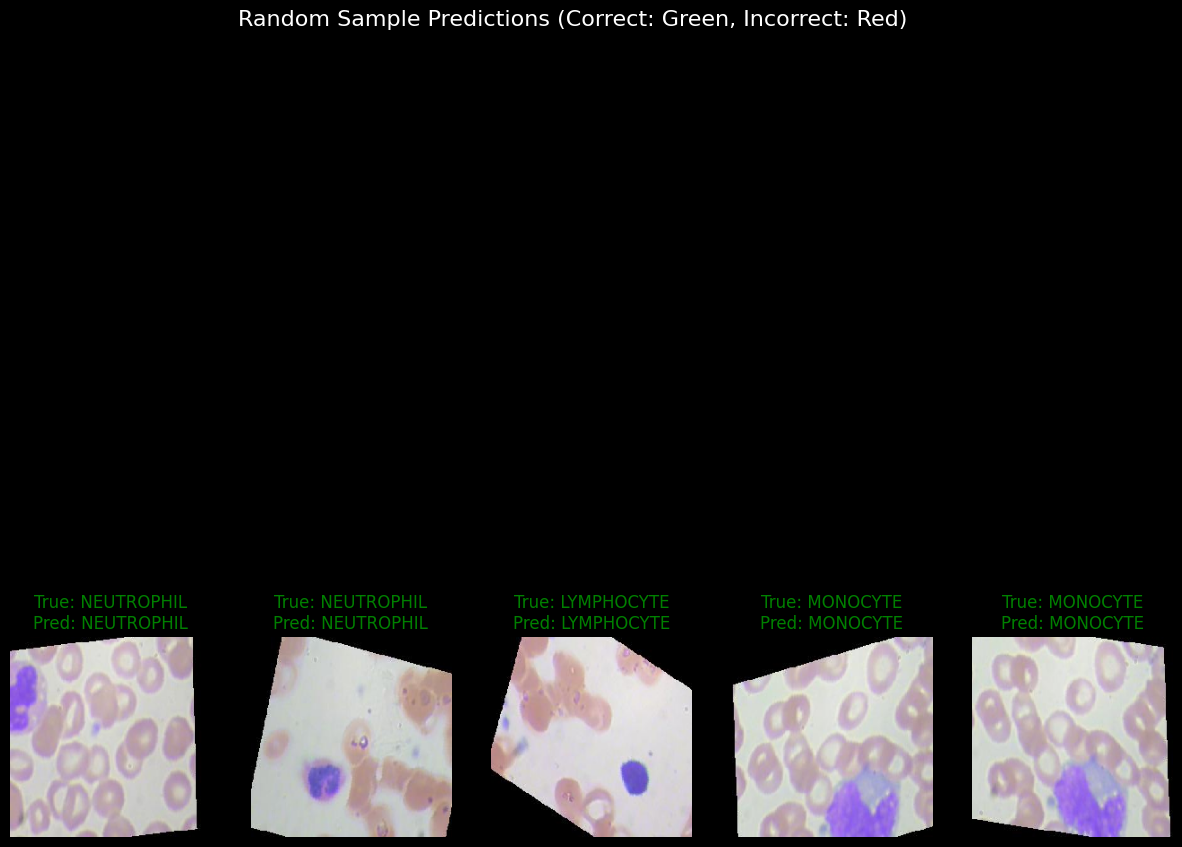

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all images and true labels from the test data generator
X_test_all = []
Y_true_all = []
test_data.reset()  # Reset the generator

for _ in range(len(test_data)):
    X_batch, Y_batch = next(test_data)  # Get a batch of data
    X_test_all.append(X_batch)
    Y_true_all.append(Y_batch)

# Concatenate all batches into single arrays
X_test_all = np.concatenate(X_test_all, axis=0)
Y_true_all = np.concatenate(Y_true_all, axis=0)

# Predict on the entire test dataset
Y_pred = model.predict(X_test_all)  # Predictions for the test set
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert predicted probabilities to class indices
Y_true_classes = np.argmax(Y_true_all, axis=1)  # Convert one-hot labels to class indices

# Define class labels (if not already defined)
class_labels = class_names  # Replace with your class names

# Function to randomly sample images and check predictions
def plot_random_samples(X_data, Y_true, Y_pred_classes, class_labels, n=10):
    random_indices = np.random.choice(len(X_data), size=n, replace=False)  # Randomly select `n` indices
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(X_data[idx])  # Assuming images are RGB
        true_label = class_labels[Y_true[idx]]  # Map integer to class name
        pred_label = class_labels[Y_pred_classes[idx]]  # Map integer to class name
        color = "green" if Y_true[idx] == Y_pred_classes[idx] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.suptitle("Random Sample Predictions (Correct: Green, Incorrect: Red)", fontsize=16)
    plt.show()

# Choose `n` random samples and visualize
n = 5  # Number of random samples to display
plot_random_samples(X_test_all, Y_true_classes, Y_pred_classes, class_labels, n=n)


In [30]:

Y_pred = model.predict(test_data)
score = model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 507ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 513ms/step - accuracy: 0.4481 - loss: 1.1135
Test loss: 0.9574158787727356
Test accuracy: 0.5830317735671997


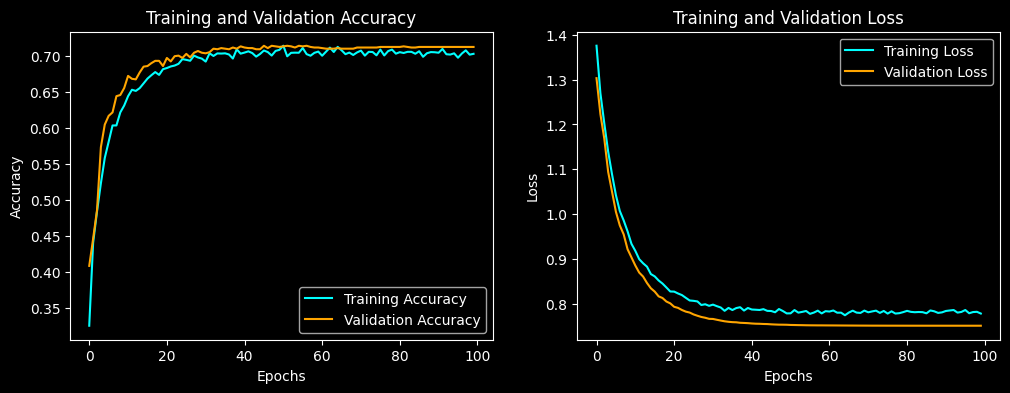

In [31]:
# Define class names (replace these with actual class names if available)
CLASS_NAMES = class_names  # Ensure 'class_names' is defined in your code

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    # Use a dark theme
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='cyan')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='cyan')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step
Classification Report:
               precision    recall  f1-score   support

  EOSINOPHIL       0.33      0.24      0.27       623
  LYMPHOCYTE       0.72      0.75      0.73       620
    MONOCYTE       0.54      0.63      0.58       620
  NEUTROPHIL       0.67      0.71      0.69       624

    accuracy                           0.58      2487
   macro avg       0.56      0.58      0.57      2487
weighted avg       0.56      0.58      0.57      2487

Precision: 0.56, Recall: 0.58, F1 Score: 0.57


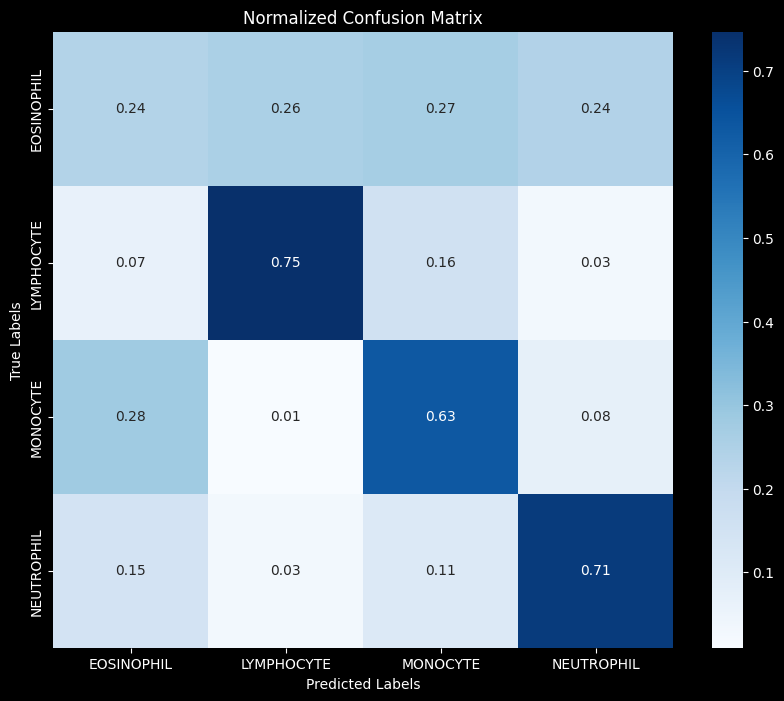

In [32]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Predict on validation data
Y_pred = model.predict(test_data)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = test_data.classes  # Actual class labels from validation data

# Generate a classification report
CLASS_NAMES = list(valid_data.class_indices.keys())  # Extract class names from validation data generator
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=class_names))

# Calculate precision, recall, and F1-score
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

# Calculate normalized confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()
